In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                                             | 0/50000 [00:00<?, ?it/s]

  9%|████████████▍                                                                                                                                  | 4339/50000 [00:00<00:01, 43384.77it/s]

 17%|████████████████████████▉                                                                                                                      | 8729/50000 [00:00<00:00, 43684.36it/s]

 26%|█████████████████████████████████████▎                                                                                                        | 13123/50000 [00:00<00:00, 43799.39it/s]

 35%|█████████████████████████████████████████████████▋                                                                                            | 17503/50000 [00:00<00:00, 43798.82it/s]

 44%|██████████████████████████████████████████████████████████████▏                                                                               | 21893/50000 [00:00<00:00, 43832.08it/s]

 53%|██████████████████████████████████████████████████████████████████████████▋                                                                   | 26277/50000 [00:00<00:00, 43701.74it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                      | 30689/50000 [00:00<00:00, 43836.33it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 35097/50000 [00:00<00:00, 43913.34it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 39489/50000 [00:00<00:00, 43882.56it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 43902/50000 [00:01<00:00, 43957.80it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 48298/50000 [00:01<00:00, 43887.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43833.58it/s]

Files already downloaded and verified


  0%|                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                 | 4312/10000 [00:00<00:00, 43116.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8682/10000 [00:00<00:00, 43453.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 43129.40it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 hzmh6lr2


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                               | 0/157 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                      | 1/157 [00:00<01:43,  1.51it/s]

  1%|█▉                                                                                                                                                     | 2/157 [00:00<00:54,  2.83it/s]

  2%|██▉                                                                                                                                                    | 3/157 [00:00<00:38,  4.01it/s]

  3%|███▊                                                                                                                                                   | 4/157 [00:01<00:30,  4.96it/s]

  3%|████▊                                                                                                                                                  | 5/157 [00:01<00:26,  5.72it/s]

  4%|█████▊                                                                                                                                                 | 6/157 [00:01<00:23,  6.30it/s]

  4%|██████▋                                                                                                                                                | 7/157 [00:01<00:22,  6.74it/s]

  5%|███████▋                                                                                                                                               | 8/157 [00:01<00:21,  7.06it/s]

  6%|████████▋                                                                                                                                              | 9/157 [00:01<00:20,  7.29it/s]

  6%|█████████▌                                                                                                                                            | 10/157 [00:01<00:19,  7.46it/s]

  7%|██████████▌                                                                                                                                           | 11/157 [00:01<00:19,  7.58it/s]

  8%|███████████▍                                                                                                                                          | 12/157 [00:02<00:18,  7.66it/s]

  8%|████████████▍                                                                                                                                         | 13/157 [00:02<00:18,  7.73it/s]

  9%|█████████████▍                                                                                                                                        | 14/157 [00:02<00:18,  7.76it/s]

 10%|██████████████▎                                                                                                                                       | 15/157 [00:02<00:18,  7.78it/s]

 10%|███████████████▎                                                                                                                                      | 16/157 [00:02<00:18,  7.80it/s]

 11%|████████████████▏                                                                                                                                     | 17/157 [00:02<00:17,  7.82it/s]

 11%|█████████████████▏                                                                                                                                    | 18/157 [00:02<00:17,  7.83it/s]

 12%|██████████████████▏                                                                                                                                   | 19/157 [00:02<00:17,  7.84it/s]

 13%|███████████████████                                                                                                                                   | 20/157 [00:03<00:17,  7.84it/s]

 13%|████████████████████                                                                                                                                  | 21/157 [00:03<00:17,  7.85it/s]

 14%|█████████████████████                                                                                                                                 | 22/157 [00:03<00:17,  7.85it/s]

 15%|█████████████████████▉                                                                                                                                | 23/157 [00:03<00:17,  7.86it/s]

 15%|██████████████████████▉                                                                                                                               | 24/157 [00:03<00:16,  7.86it/s]

 16%|███████████████████████▉                                                                                                                              | 25/157 [00:03<00:16,  7.86it/s]

 17%|████████████████████████▊                                                                                                                             | 26/157 [00:03<00:16,  7.87it/s]

 17%|█████████████████████████▊                                                                                                                            | 27/157 [00:03<00:16,  7.87it/s]

 18%|██████████████████████████▊                                                                                                                           | 28/157 [00:04<00:16,  7.87it/s]

 18%|███████████████████████████▋                                                                                                                          | 29/157 [00:04<00:16,  7.87it/s]

 19%|████████████████████████████▋                                                                                                                         | 30/157 [00:04<00:16,  7.87it/s]

 20%|█████████████████████████████▌                                                                                                                        | 31/157 [00:04<00:16,  7.87it/s]

 20%|██████████████████████████████▌                                                                                                                       | 32/157 [00:04<00:15,  7.87it/s]

 21%|███████████████████████████████▌                                                                                                                      | 33/157 [00:04<00:15,  7.87it/s]

 22%|████████████████████████████████▍                                                                                                                     | 34/157 [00:04<00:15,  7.86it/s]

 22%|█████████████████████████████████▍                                                                                                                    | 35/157 [00:04<00:15,  7.86it/s]

 23%|██████████████████████████████████▍                                                                                                                   | 36/157 [00:05<00:15,  7.86it/s]

 24%|███████████████████████████████████▎                                                                                                                  | 37/157 [00:05<00:15,  7.86it/s]

 24%|████████████████████████████████████▎                                                                                                                 | 38/157 [00:05<00:15,  7.86it/s]

 25%|█████████████████████████████████████▎                                                                                                                | 39/157 [00:05<00:15,  7.86it/s]

 25%|██████████████████████████████████████▏                                                                                                               | 40/157 [00:05<00:14,  7.87it/s]

 26%|███████████████████████████████████████▏                                                                                                              | 41/157 [00:05<00:14,  7.86it/s]

 27%|████████████████████████████████████████▏                                                                                                             | 42/157 [00:05<00:14,  7.87it/s]

 27%|█████████████████████████████████████████                                                                                                             | 43/157 [00:06<00:14,  7.86it/s]

 28%|██████████████████████████████████████████                                                                                                            | 44/157 [00:06<00:14,  7.87it/s]

 29%|██████████████████████████████████████████▉                                                                                                           | 45/157 [00:06<00:14,  7.87it/s]

 29%|███████████████████████████████████████████▉                                                                                                          | 46/157 [00:06<00:14,  7.87it/s]

 30%|████████████████████████████████████████████▉                                                                                                         | 47/157 [00:06<00:14,  7.86it/s]

 31%|█████████████████████████████████████████████▊                                                                                                        | 48/157 [00:06<00:13,  7.84it/s]

 31%|██████████████████████████████████████████████▊                                                                                                       | 49/157 [00:06<00:13,  7.84it/s]

 32%|███████████████████████████████████████████████▊                                                                                                      | 50/157 [00:06<00:13,  7.84it/s]

 32%|████████████████████████████████████████████████▋                                                                                                     | 51/157 [00:07<00:13,  7.84it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                    | 52/157 [00:07<00:13,  7.84it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                   | 53/157 [00:07<00:13,  7.83it/s]

 34%|███████████████████████████████████████████████████▌                                                                                                  | 54/157 [00:07<00:13,  7.83it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                 | 55/157 [00:07<00:13,  7.83it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                                | 56/157 [00:07<00:12,  7.84it/s]

 36%|██████████████████████████████████████████████████████▍                                                                                               | 57/157 [00:07<00:12,  7.84it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                              | 58/157 [00:07<00:12,  7.85it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                             | 59/157 [00:08<00:12,  7.86it/s]

 38%|█████████████████████████████████████████████████████████▎                                                                                            | 60/157 [00:08<00:12,  7.86it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                           | 61/157 [00:08<00:12,  7.86it/s]

 39%|███████████████████████████████████████████████████████████▏                                                                                          | 62/157 [00:08<00:12,  7.85it/s]

 40%|████████████████████████████████████████████████████████████▏                                                                                         | 63/157 [00:08<00:11,  7.85it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                        | 64/157 [00:08<00:11,  7.86it/s]

 41%|██████████████████████████████████████████████████████████████                                                                                        | 65/157 [00:08<00:11,  7.86it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 66/157 [00:08<00:11,  7.86it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                      | 67/157 [00:09<00:11,  7.85it/s]

 43%|████████████████████████████████████████████████████████████████▉                                                                                     | 68/157 [00:09<00:11,  7.84it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                    | 69/157 [00:09<00:11,  7.82it/s]

 45%|██████████████████████████████████████████████████████████████████▉                                                                                   | 70/157 [00:09<00:11,  7.82it/s]

 45%|███████████████████████████████████████████████████████████████████▊                                                                                  | 71/157 [00:09<00:10,  7.84it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                                 | 72/157 [00:09<00:10,  7.84it/s]

 46%|█████████████████████████████████████████████████████████████████████▋                                                                                | 73/157 [00:09<00:10,  7.85it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                               | 74/157 [00:09<00:10,  7.85it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                              | 75/157 [00:10<00:10,  7.85it/s]

 48%|████████████████████████████████████████████████████████████████████████▌                                                                             | 76/157 [00:10<00:10,  7.85it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 77/157 [00:10<00:10,  7.85it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                           | 78/157 [00:10<00:10,  7.85it/s]

 50%|███████████████████████████████████████████████████████████████████████████▍                                                                          | 79/157 [00:10<00:09,  7.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                         | 80/157 [00:10<00:09,  7.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                        | 81/157 [00:10<00:09,  7.84it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                       | 82/157 [00:10<00:09,  7.83it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                      | 83/157 [00:11<00:09,  7.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                     | 84/157 [00:11<00:09,  7.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                    | 85/157 [00:11<00:09,  7.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                   | 86/157 [00:11<00:09,  7.84it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                   | 87/157 [00:11<00:08,  7.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 88/157 [00:11<00:08,  7.83it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                 | 89/157 [00:11<00:08,  7.81it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                | 90/157 [00:12<00:08,  7.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                               | 91/157 [00:12<00:08,  7.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                              | 92/157 [00:12<00:08,  7.84it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/157 [00:12<00:08,  7.85it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 94/157 [00:12<00:08,  7.86it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 95/157 [00:12<00:07,  7.86it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 96/157 [00:12<00:07,  7.86it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 97/157 [00:12<00:07,  7.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 98/157 [00:13<00:07,  7.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 99/157 [00:13<00:07,  7.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 100/157 [00:13<00:07,  7.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 101/157 [00:13<00:07,  7.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 102/157 [00:13<00:06,  7.86it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 103/157 [00:13<00:06,  7.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 104/157 [00:13<00:06,  7.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 105/157 [00:13<00:06,  7.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 106/157 [00:14<00:06,  7.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 107/157 [00:14<00:06,  7.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 108/157 [00:14<00:06,  7.85it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 109/157 [00:14<00:06,  7.85it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 110/157 [00:14<00:05,  7.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 111/157 [00:14<00:05,  7.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 112/157 [00:14<00:05,  7.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 113/157 [00:14<00:05,  7.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 114/157 [00:15<00:05,  7.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 115/157 [00:15<00:05,  7.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 116/157 [00:15<00:05,  7.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 117/157 [00:15<00:05,  7.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 118/157 [00:15<00:04,  7.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 119/157 [00:15<00:04,  7.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 120/157 [00:15<00:04,  7.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 121/157 [00:15<00:04,  7.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 122/157 [00:16<00:04,  7.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 123/157 [00:16<00:04,  7.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 124/157 [00:16<00:04,  7.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 125/157 [00:16<00:04,  7.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 126/157 [00:16<00:03,  7.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 127/157 [00:16<00:03,  7.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 128/157 [00:16<00:03,  7.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 129/157 [00:16<00:03,  7.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 130/157 [00:17<00:03,  7.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 131/157 [00:17<00:03,  7.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 132/157 [00:17<00:03,  7.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 133/157 [00:17<00:03,  7.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 134/157 [00:17<00:02,  7.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 135/157 [00:17<00:02,  7.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 136/157 [00:17<00:02,  7.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 137/157 [00:17<00:02,  7.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 138/157 [00:18<00:02,  7.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 139/157 [00:18<00:02,  7.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 140/157 [00:18<00:02,  7.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 141/157 [00:18<00:02,  7.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 142/157 [00:18<00:01,  7.84it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 143/157 [00:18<00:01,  7.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 144/157 [00:18<00:01,  7.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 145/157 [00:19<00:01,  7.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 146/157 [00:19<00:01,  7.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 147/157 [00:19<00:01,  7.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 148/157 [00:19<00:01,  7.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 149/157 [00:19<00:01,  7.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 150/157 [00:19<00:00,  7.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 151/157 [00:19<00:00,  7.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 152/157 [00:19<00:00,  7.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 153/157 [00:20<00:00,  7.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 154/157 [00:20<00:00,  7.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 155/157 [00:20<00:00,  7.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 156/157 [00:20<00:00,  7.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.66it/s]

train - OK


  0%|                                                                                                                                                                | 0/40 [00:00<?, ?it/s]

  2%|███▊                                                                                                                                                    | 1/40 [00:00<00:08,  4.48it/s]

  5%|███████▌                                                                                                                                                | 2/40 [00:00<00:06,  5.98it/s]

  8%|███████████▍                                                                                                                                            | 3/40 [00:00<00:05,  6.72it/s]

 10%|███████████████▏                                                                                                                                        | 4/40 [00:00<00:05,  7.13it/s]

 12%|███████████████████                                                                                                                                     | 5/40 [00:00<00:04,  7.38it/s]

 15%|██████████████████████▊                                                                                                                                 | 6/40 [00:00<00:04,  7.53it/s]

 18%|██████████████████████████▌                                                                                                                             | 7/40 [00:00<00:04,  7.64it/s]

 20%|██████████████████████████████▍                                                                                                                         | 8/40 [00:01<00:04,  7.71it/s]

 22%|██████████████████████████████████▏                                                                                                                     | 9/40 [00:01<00:03,  7.75it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 10/40 [00:01<00:03,  7.77it/s]

 28%|█████████████████████████████████████████▌                                                                                                             | 11/40 [00:01<00:03,  7.79it/s]

 30%|█████████████████████████████████████████████▎                                                                                                         | 12/40 [00:01<00:03,  7.81it/s]

 32%|█████████████████████████████████████████████████                                                                                                      | 13/40 [00:01<00:03,  7.82it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                  | 14/40 [00:01<00:03,  7.83it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                              | 15/40 [00:02<00:03,  7.84it/s]

 40%|████████████████████████████████████████████████████████████▍                                                                                          | 16/40 [00:02<00:03,  7.84it/s]

 42%|████████████████████████████████████████████████████████████████▏                                                                                      | 17/40 [00:02<00:02,  7.85it/s]

 45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 18/40 [00:02<00:02,  7.86it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 19/40 [00:02<00:02,  7.86it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 20/40 [00:02<00:02,  7.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 21/40 [00:02<00:02,  7.86it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 22/40 [00:02<00:02,  7.85it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 23/40 [00:03<00:02,  7.86it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 24/40 [00:03<00:02,  7.86it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 25/40 [00:03<00:01,  7.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 26/40 [00:03<00:01,  7.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 27/40 [00:03<00:01,  7.84it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 28/40 [00:03<00:01,  7.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 29/40 [00:03<00:01,  7.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 30/40 [00:03<00:01,  7.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 31/40 [00:04<00:01,  7.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 32/40 [00:04<00:01,  7.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 33/40 [00:04<00:00,  7.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 34/40 [00:04<00:00,  7.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 35/40 [00:04<00:00,  7.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 36/40 [00:04<00:00,  7.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 37/40 [00:04<00:00,  7.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 38/40 [00:04<00:00,  7.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 39/40 [00:05<00:00,  7.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.77it/s]

val - OK


  0%|                                                                                                                                                                | 0/40 [00:00<?, ?it/s]

  2%|███▊                                                                                                                                                    | 1/40 [00:00<00:08,  4.36it/s]

  5%|███████▌                                                                                                                                                | 2/40 [00:00<00:06,  5.88it/s]

  8%|███████████▍                                                                                                                                            | 3/40 [00:00<00:05,  6.64it/s]

 10%|███████████████▏                                                                                                                                        | 4/40 [00:00<00:05,  7.07it/s]

 12%|███████████████████                                                                                                                                     | 5/40 [00:00<00:04,  7.33it/s]

 15%|██████████████████████▊                                                                                                                                 | 6/40 [00:00<00:04,  7.50it/s]

 18%|██████████████████████████▌                                                                                                                             | 7/40 [00:00<00:04,  7.61it/s]

 20%|██████████████████████████████▍                                                                                                                         | 8/40 [00:01<00:04,  7.69it/s]

 22%|██████████████████████████████████▏                                                                                                                     | 9/40 [00:01<00:04,  7.73it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 10/40 [00:01<00:03,  7.77it/s]

 28%|█████████████████████████████████████████▌                                                                                                             | 11/40 [00:01<00:03,  7.80it/s]

 30%|█████████████████████████████████████████████▎                                                                                                         | 12/40 [00:01<00:03,  7.80it/s]

 32%|█████████████████████████████████████████████████                                                                                                      | 13/40 [00:01<00:03,  7.82it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                  | 14/40 [00:01<00:03,  7.83it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                              | 15/40 [00:02<00:03,  7.84it/s]

 40%|████████████████████████████████████████████████████████████▍                                                                                          | 16/40 [00:02<00:03,  7.83it/s]

 42%|████████████████████████████████████████████████████████████████▏                                                                                      | 17/40 [00:02<00:02,  7.84it/s]

 45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 18/40 [00:02<00:02,  7.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 19/40 [00:02<00:02,  7.83it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 20/40 [00:02<00:02,  7.83it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 21/40 [00:02<00:02,  7.83it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 22/40 [00:02<00:02,  7.83it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 23/40 [00:03<00:02,  7.83it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 24/40 [00:03<00:02,  7.84it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 25/40 [00:03<00:01,  7.83it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 26/40 [00:03<00:01,  7.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 27/40 [00:03<00:01,  7.84it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 28/40 [00:03<00:01,  7.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 29/40 [00:03<00:01,  7.84it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 30/40 [00:03<00:01,  7.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 31/40 [00:04<00:01,  7.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 32/40 [00:04<00:01,  7.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 33/40 [00:04<00:00,  7.84it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 34/40 [00:04<00:00,  7.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 35/40 [00:04<00:00,  7.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 36/40 [00:04<00:00,  7.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 37/40 [00:04<00:00,  7.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 38/40 [00:04<00:00,  7.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 39/40 [00:05<00:00,  7.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.78it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/235 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                      | 1/235 [00:00<00:56,  4.14it/s]

  1%|█▎                                                                                                                                                     | 2/235 [00:00<00:40,  5.70it/s]

  1%|█▉                                                                                                                                                     | 3/235 [00:00<00:35,  6.50it/s]

  2%|██▌                                                                                                                                                    | 4/235 [00:00<00:33,  6.96it/s]

  2%|███▏                                                                                                                                                   | 5/235 [00:00<00:31,  7.23it/s]

  3%|███▊                                                                                                                                                   | 6/235 [00:00<00:30,  7.40it/s]

  3%|████▍                                                                                                                                                  | 7/235 [00:01<00:30,  7.52it/s]

  3%|█████▏                                                                                                                                                 | 8/235 [00:01<00:29,  7.60it/s]

  4%|█████▊                                                                                                                                                 | 9/235 [00:01<00:29,  7.65it/s]

  4%|██████▍                                                                                                                                               | 10/235 [00:01<00:29,  7.69it/s]

  5%|███████                                                                                                                                               | 11/235 [00:01<00:29,  7.71it/s]

  5%|███████▋                                                                                                                                              | 12/235 [00:01<00:28,  7.72it/s]

  6%|████████▎                                                                                                                                             | 13/235 [00:01<00:28,  7.74it/s]

  6%|████████▉                                                                                                                                             | 14/235 [00:01<00:28,  7.76it/s]

  6%|█████████▌                                                                                                                                            | 15/235 [00:02<00:28,  7.78it/s]

  7%|██████████▏                                                                                                                                           | 16/235 [00:02<00:28,  7.79it/s]

  7%|██████████▊                                                                                                                                           | 17/235 [00:02<00:27,  7.80it/s]

  8%|███████████▍                                                                                                                                          | 18/235 [00:02<00:27,  7.81it/s]

  8%|████████████▏                                                                                                                                         | 19/235 [00:02<00:27,  7.82it/s]

  9%|████████████▊                                                                                                                                         | 20/235 [00:02<00:27,  7.82it/s]

  9%|█████████████▍                                                                                                                                        | 21/235 [00:02<00:27,  7.82it/s]

  9%|██████████████                                                                                                                                        | 22/235 [00:02<00:27,  7.82it/s]

 10%|██████████████▋                                                                                                                                       | 23/235 [00:03<00:27,  7.82it/s]

 10%|███████████████▎                                                                                                                                      | 24/235 [00:03<00:26,  7.83it/s]

 11%|███████████████▉                                                                                                                                      | 25/235 [00:03<00:26,  7.82it/s]

 11%|████████████████▌                                                                                                                                     | 26/235 [00:03<00:26,  7.82it/s]

 11%|█████████████████▏                                                                                                                                    | 27/235 [00:03<00:26,  7.83it/s]

 12%|█████████████████▊                                                                                                                                    | 28/235 [00:03<00:26,  7.83it/s]

 12%|██████████████████▌                                                                                                                                   | 29/235 [00:03<00:26,  7.83it/s]

 13%|███████████████████▏                                                                                                                                  | 30/235 [00:03<00:26,  7.83it/s]

 13%|███████████████████▊                                                                                                                                  | 31/235 [00:04<00:26,  7.83it/s]

 14%|████████████████████▍                                                                                                                                 | 32/235 [00:04<00:25,  7.82it/s]

 14%|█████████████████████                                                                                                                                 | 33/235 [00:04<00:25,  7.82it/s]

 14%|█████████████████████▋                                                                                                                                | 34/235 [00:04<00:25,  7.81it/s]

 15%|██████████████████████▎                                                                                                                               | 35/235 [00:04<00:25,  7.82it/s]

 15%|██████████████████████▉                                                                                                                               | 36/235 [00:04<00:25,  7.81it/s]

 16%|███████████████████████▌                                                                                                                              | 37/235 [00:04<00:25,  7.80it/s]

 16%|████████████████████████▎                                                                                                                             | 38/235 [00:04<00:25,  7.78it/s]

 17%|████████████████████████▉                                                                                                                             | 39/235 [00:05<00:25,  7.79it/s]

 17%|█████████████████████████▌                                                                                                                            | 40/235 [00:05<00:25,  7.79it/s]

 17%|██████████████████████████▏                                                                                                                           | 41/235 [00:05<00:24,  7.79it/s]

 18%|██████████████████████████▊                                                                                                                           | 42/235 [00:05<00:24,  7.79it/s]

 18%|███████████████████████████▍                                                                                                                          | 43/235 [00:05<00:24,  7.79it/s]

 19%|████████████████████████████                                                                                                                          | 44/235 [00:05<00:24,  7.79it/s]

 19%|████████████████████████████▋                                                                                                                         | 45/235 [00:05<00:24,  7.80it/s]

 20%|█████████████████████████████▎                                                                                                                        | 46/235 [00:06<00:24,  7.80it/s]

 20%|██████████████████████████████                                                                                                                        | 47/235 [00:06<00:24,  7.81it/s]

 20%|██████████████████████████████▋                                                                                                                       | 48/235 [00:06<00:23,  7.82it/s]

 21%|███████████████████████████████▎                                                                                                                      | 49/235 [00:06<00:23,  7.82it/s]

 21%|███████████████████████████████▉                                                                                                                      | 50/235 [00:06<00:23,  7.80it/s]

 22%|████████████████████████████████▌                                                                                                                     | 51/235 [00:06<00:23,  7.79it/s]

 22%|█████████████████████████████████▏                                                                                                                    | 52/235 [00:06<00:23,  7.78it/s]

 23%|█████████████████████████████████▊                                                                                                                    | 53/235 [00:06<00:23,  7.75it/s]

 23%|██████████████████████████████████▍                                                                                                                   | 54/235 [00:07<00:23,  7.76it/s]

 23%|███████████████████████████████████                                                                                                                   | 55/235 [00:07<00:23,  7.77it/s]

 24%|███████████████████████████████████▋                                                                                                                  | 56/235 [00:07<00:23,  7.78it/s]

 24%|████████████████████████████████████▍                                                                                                                 | 57/235 [00:07<00:22,  7.79it/s]

 25%|█████████████████████████████████████                                                                                                                 | 58/235 [00:07<00:22,  7.79it/s]

 25%|█████████████████████████████████████▋                                                                                                                | 59/235 [00:07<00:22,  7.81it/s]

 26%|██████████████████████████████████████▎                                                                                                               | 60/235 [00:07<00:22,  7.81it/s]

 26%|██████████████████████████████████████▉                                                                                                               | 61/235 [00:07<00:22,  7.82it/s]

 26%|███████████████████████████████████████▌                                                                                                              | 62/235 [00:08<00:22,  7.82it/s]

 27%|████████████████████████████████████████▏                                                                                                             | 63/235 [00:08<00:21,  7.83it/s]

 27%|████████████████████████████████████████▊                                                                                                             | 64/235 [00:08<00:21,  7.82it/s]

 28%|█████████████████████████████████████████▍                                                                                                            | 65/235 [00:08<00:21,  7.83it/s]

 28%|██████████████████████████████████████████▏                                                                                                           | 66/235 [00:08<00:21,  7.83it/s]

 29%|██████████████████████████████████████████▊                                                                                                           | 67/235 [00:08<00:21,  7.82it/s]

 29%|███████████████████████████████████████████▍                                                                                                          | 68/235 [00:08<00:21,  7.82it/s]

 29%|████████████████████████████████████████████                                                                                                          | 69/235 [00:08<00:21,  7.82it/s]

 30%|████████████████████████████████████████████▋                                                                                                         | 70/235 [00:09<00:21,  7.81it/s]

 30%|█████████████████████████████████████████████▎                                                                                                        | 71/235 [00:09<00:21,  7.81it/s]

 31%|█████████████████████████████████████████████▉                                                                                                        | 72/235 [00:09<00:20,  7.81it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 73/235 [00:09<00:20,  7.80it/s]

 31%|███████████████████████████████████████████████▏                                                                                                      | 74/235 [00:09<00:20,  7.79it/s]

 32%|███████████████████████████████████████████████▊                                                                                                      | 75/235 [00:09<00:20,  7.79it/s]

 32%|████████████████████████████████████████████████▌                                                                                                     | 76/235 [00:09<00:20,  7.79it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                    | 77/235 [00:09<00:20,  7.79it/s]

 33%|█████████████████████████████████████████████████▊                                                                                                    | 78/235 [00:10<00:20,  7.78it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                   | 79/235 [00:10<00:20,  7.77it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 80/235 [00:10<00:19,  7.78it/s]

 34%|███████████████████████████████████████████████████▋                                                                                                  | 81/235 [00:10<00:19,  7.78it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                 | 82/235 [00:10<00:19,  7.78it/s]

 35%|████████████████████████████████████████████████████▉                                                                                                 | 83/235 [00:10<00:19,  7.78it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                                | 84/235 [00:10<00:19,  7.78it/s]

 36%|██████████████████████████████████████████████████████▎                                                                                               | 85/235 [00:11<00:19,  7.77it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                               | 86/235 [00:11<00:19,  7.77it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                              | 87/235 [00:11<00:19,  7.77it/s]

 37%|████████████████████████████████████████████████████████▏                                                                                             | 88/235 [00:11<00:18,  7.77it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                             | 89/235 [00:11<00:18,  7.76it/s]

 38%|█████████████████████████████████████████████████████████▍                                                                                            | 90/235 [00:11<00:18,  7.77it/s]

 39%|██████████████████████████████████████████████████████████                                                                                            | 91/235 [00:11<00:18,  7.78it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                           | 92/235 [00:11<00:18,  7.80it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                          | 93/235 [00:12<00:18,  7.80it/s]

 40%|████████████████████████████████████████████████████████████                                                                                          | 94/235 [00:12<00:18,  7.81it/s]

 40%|████████████████████████████████████████████████████████████▋                                                                                         | 95/235 [00:12<00:17,  7.82it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                        | 96/235 [00:12<00:17,  7.82it/s]

 41%|█████████████████████████████████████████████████████████████▉                                                                                        | 97/235 [00:12<00:17,  7.82it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                       | 98/235 [00:12<00:17,  7.83it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                      | 99/235 [00:12<00:17,  7.83it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                     | 100/235 [00:12<00:17,  7.83it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                     | 101/235 [00:13<00:17,  7.83it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 102/235 [00:13<00:16,  7.83it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                   | 103/235 [00:13<00:16,  7.82it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                   | 104/235 [00:13<00:16,  7.81it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 105/235 [00:13<00:16,  7.80it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 106/235 [00:13<00:16,  7.79it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                                 | 107/235 [00:13<00:16,  7.80it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                                | 108/235 [00:13<00:16,  7.80it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 109/235 [00:14<00:16,  7.81it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                               | 110/235 [00:14<00:16,  7.81it/s]

 47%|██████████████████████████████████████████████████████████████████████▍                                                                              | 111/235 [00:14<00:15,  7.81it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                              | 112/235 [00:14<00:15,  7.81it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                             | 113/235 [00:14<00:15,  7.82it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                            | 114/235 [00:14<00:15,  7.82it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 115/235 [00:14<00:15,  7.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 116/235 [00:14<00:15,  7.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                          | 117/235 [00:15<00:15,  7.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▊                                                                          | 118/235 [00:15<00:14,  7.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 119/235 [00:15<00:14,  7.82it/s]

 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 120/235 [00:15<00:14,  7.82it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 121/235 [00:15<00:14,  7.81it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                       | 122/235 [00:15<00:14,  7.80it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                       | 123/235 [00:15<00:14,  7.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                      | 124/235 [00:16<00:14,  7.81it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                     | 125/235 [00:16<00:14,  7.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 126/235 [00:16<00:13,  7.81it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                    | 127/235 [00:16<00:13,  7.81it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                   | 128/235 [00:16<00:13,  7.80it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 129/235 [00:16<00:13,  7.81it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 130/235 [00:16<00:13,  7.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 131/235 [00:16<00:13,  7.80it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                 | 132/235 [00:17<00:13,  7.80it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 133/235 [00:17<00:13,  7.81it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▉                                                                | 134/235 [00:17<00:12,  7.81it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                               | 135/235 [00:17<00:12,  7.81it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 136/235 [00:17<00:12,  7.81it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▊                                                              | 137/235 [00:17<00:12,  7.81it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                             | 138/235 [00:17<00:12,  7.82it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 139/235 [00:17<00:12,  7.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 140/235 [00:18<00:12,  7.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 141/235 [00:18<00:12,  7.83it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                           | 142/235 [00:18<00:11,  7.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 143/235 [00:18<00:11,  7.82it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 144/235 [00:18<00:11,  7.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 145/235 [00:18<00:11,  7.82it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 146/235 [00:18<00:11,  7.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 147/235 [00:18<00:11,  7.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 148/235 [00:19<00:11,  7.82it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 149/235 [00:19<00:11,  7.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                      | 150/235 [00:19<00:10,  7.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 151/235 [00:19<00:10,  7.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 152/235 [00:19<00:10,  7.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 153/235 [00:19<00:10,  7.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 154/235 [00:19<00:10,  7.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 155/235 [00:19<00:10,  7.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 156/235 [00:20<00:10,  7.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 157/235 [00:20<00:09,  7.83it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 158/235 [00:20<00:09,  7.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 159/235 [00:20<00:09,  7.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 160/235 [00:20<00:09,  7.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 161/235 [00:20<00:09,  7.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 162/235 [00:20<00:09,  7.84it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 163/235 [00:20<00:09,  7.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 164/235 [00:21<00:09,  7.83it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 165/235 [00:21<00:08,  7.84it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 166/235 [00:21<00:08,  7.83it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 167/235 [00:21<00:08,  7.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 168/235 [00:21<00:08,  7.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 169/235 [00:21<00:08,  7.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 170/235 [00:21<00:08,  7.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 171/235 [00:22<00:08,  7.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 172/235 [00:22<00:08,  7.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 173/235 [00:22<00:07,  7.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 174/235 [00:22<00:07,  7.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 175/235 [00:22<00:07,  7.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 176/235 [00:22<00:07,  7.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 177/235 [00:22<00:07,  7.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 178/235 [00:22<00:07,  7.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 179/235 [00:23<00:07,  7.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 180/235 [00:23<00:07,  7.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 181/235 [00:23<00:06,  7.81it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 182/235 [00:23<00:06,  7.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 183/235 [00:23<00:06,  7.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 184/235 [00:23<00:06,  7.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 185/235 [00:23<00:06,  7.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 186/235 [00:23<00:06,  7.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 187/235 [00:24<00:06,  7.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 188/235 [00:24<00:06,  7.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 189/235 [00:24<00:05,  7.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 190/235 [00:24<00:05,  7.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 191/235 [00:24<00:05,  7.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 192/235 [00:24<00:05,  7.82it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 193/235 [00:24<00:05,  7.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 194/235 [00:24<00:05,  7.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 195/235 [00:25<00:05,  7.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 196/235 [00:25<00:04,  7.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 197/235 [00:25<00:04,  7.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 198/235 [00:25<00:04,  7.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 199/235 [00:25<00:04,  7.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 200/235 [00:25<00:04,  7.83it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 201/235 [00:25<00:04,  7.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 202/235 [00:25<00:04,  7.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 203/235 [00:26<00:04,  7.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 204/235 [00:26<00:03,  7.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 205/235 [00:26<00:03,  7.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 206/235 [00:26<00:03,  7.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 207/235 [00:26<00:03,  7.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 208/235 [00:26<00:03,  7.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 209/235 [00:26<00:03,  7.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 210/235 [00:27<00:03,  7.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 211/235 [00:27<00:03,  7.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 212/235 [00:27<00:02,  7.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 213/235 [00:27<00:02,  7.83it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 214/235 [00:27<00:02,  7.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 215/235 [00:27<00:02,  7.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 216/235 [00:27<00:02,  7.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 217/235 [00:27<00:02,  7.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 218/235 [00:28<00:02,  7.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 219/235 [00:28<00:02,  7.82it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 220/235 [00:28<00:01,  7.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 221/235 [00:28<00:01,  7.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 222/235 [00:28<00:01,  7.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 223/235 [00:28<00:01,  7.82it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 224/235 [00:28<00:01,  7.83it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 225/235 [00:28<00:01,  7.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 226/235 [00:29<00:01,  7.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 227/235 [00:29<00:01,  7.83it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 228/235 [00:29<00:00,  7.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 229/235 [00:29<00:00,  7.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 230/235 [00:29<00:00,  7.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 231/235 [00:29<00:00,  7.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 232/235 [00:29<00:00,  7.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 233/235 [00:29<00:00,  7.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 234/235 [00:30<00:00,  7.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:30<00:00,  7.78it/s]

test OoD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                     | 1/100 [00:00<00:11,  8.89it/s]

  2%|███                                                                                                                                                    | 2/100 [00:00<00:10,  8.93it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:10,  8.95it/s]

  4%|██████                                                                                                                                                 | 4/100 [00:00<00:10,  8.95it/s]

  5%|███████▌                                                                                                                                               | 5/100 [00:00<00:10,  8.96it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:10,  8.96it/s]

  7%|██████████▌                                                                                                                                            | 7/100 [00:00<00:10,  8.96it/s]

  8%|████████████                                                                                                                                           | 8/100 [00:00<00:10,  8.96it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:01<00:10,  8.96it/s]

 10%|███████████████                                                                                                                                       | 10/100 [00:01<00:10,  8.96it/s]

 11%|████████████████▌                                                                                                                                     | 11/100 [00:01<00:09,  8.96it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:01<00:09,  8.96it/s]

 13%|███████████████████▌                                                                                                                                  | 13/100 [00:01<00:09,  8.97it/s]

 14%|█████████████████████                                                                                                                                 | 14/100 [00:01<00:09,  8.97it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:01<00:09,  8.97it/s]

 16%|████████████████████████                                                                                                                              | 16/100 [00:01<00:09,  8.97it/s]

 17%|█████████████████████████▌                                                                                                                            | 17/100 [00:01<00:09,  8.96it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:02<00:09,  8.97it/s]

 19%|████████████████████████████▌                                                                                                                         | 19/100 [00:02<00:09,  8.97it/s]

 20%|██████████████████████████████                                                                                                                        | 20/100 [00:02<00:08,  8.97it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:02<00:08,  8.97it/s]

 22%|█████████████████████████████████                                                                                                                     | 22/100 [00:02<00:08,  8.98it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 23/100 [00:02<00:08,  8.98it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:02<00:08,  8.98it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 25/100 [00:02<00:08,  8.98it/s]

 26%|███████████████████████████████████████                                                                                                               | 26/100 [00:02<00:08,  8.98it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:03<00:08,  8.98it/s]

 28%|██████████████████████████████████████████                                                                                                            | 28/100 [00:03<00:08,  8.98it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 29/100 [00:03<00:07,  8.97it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:03<00:07,  8.97it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 31/100 [00:03<00:07,  8.97it/s]

 32%|████████████████████████████████████████████████                                                                                                      | 32/100 [00:03<00:07,  8.98it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:03<00:07,  8.97it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 34/100 [00:03<00:07,  8.98it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                 | 35/100 [00:03<00:07,  8.98it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:04<00:07,  8.97it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                              | 37/100 [00:04<00:07,  8.97it/s]

 38%|█████████████████████████████████████████████████████████                                                                                             | 38/100 [00:04<00:06,  8.97it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:04<00:06,  8.98it/s]

 40%|████████████████████████████████████████████████████████████                                                                                          | 40/100 [00:04<00:06,  8.97it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 41/100 [00:04<00:06,  8.97it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:04<00:06,  8.98it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 43/100 [00:04<00:06,  8.98it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                    | 44/100 [00:04<00:06,  8.98it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:05<00:06,  8.97it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 46/100 [00:05<00:06,  8.97it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                               | 47/100 [00:05<00:05,  8.96it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:05<00:05,  8.96it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 49/100 [00:05<00:05,  8.96it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 50/100 [00:05<00:05,  8.96it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:05<00:05,  8.97it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 52/100 [00:05<00:05,  8.97it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 53/100 [00:05<00:05,  8.97it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:06<00:05,  8.97it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 55/100 [00:06<00:05,  8.97it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 56/100 [00:06<00:04,  8.97it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:06<00:04,  8.98it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 58/100 [00:06<00:04,  8.98it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 59/100 [00:06<00:04,  8.97it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:06<00:04,  8.98it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 61/100 [00:06<00:04,  8.98it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 62/100 [00:06<00:04,  8.98it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:07<00:04,  8.98it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 64/100 [00:07<00:04,  8.97it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 65/100 [00:07<00:03,  8.97it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:07<00:03,  8.97it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/100 [00:07<00:03,  8.97it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 68/100 [00:07<00:03,  8.97it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:07<00:03,  8.97it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 70/100 [00:07<00:03,  8.97it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 71/100 [00:07<00:03,  8.97it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:08<00:03,  8.98it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 73/100 [00:08<00:03,  8.97it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 74/100 [00:08<00:02,  8.97it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:08<00:02,  8.97it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 76/100 [00:08<00:02,  8.98it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 77/100 [00:08<00:02,  8.97it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:08<00:02,  8.97it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 79/100 [00:08<00:02,  8.98it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 80/100 [00:08<00:02,  8.98it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:09<00:02,  8.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 82/100 [00:09<00:02,  8.98it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 83/100 [00:09<00:01,  8.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:09<00:01,  8.97it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 85/100 [00:09<00:01,  8.96it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 86/100 [00:09<00:01,  8.96it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:09<00:01,  8.96it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [00:09<00:01,  8.96it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [00:09<00:01,  8.97it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:10<00:01,  8.97it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [00:10<00:01,  8.97it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [00:10<00:00,  8.97it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:10<00:00,  8.97it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [00:10<00:00,  8.97it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [00:10<00:00,  8.97it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:10<00:00,  8.97it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:10<00:00,  8.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:10<00:00,  8.97it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:11<00:00,  8.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.97it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(20000, 3, 32, 32) (20000, 512) (20000, 2560) (20000, 3, 32, 32) (20000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(30000, 3, 32, 32) (30000, 512) (30000, 2560) (30000, 3, 32, 32) (30000,)
(12800, 3, 32, 32) (12800, 512) (12800, 2560) (12800, 3, 32, 32)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (30000, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (30000, 2)


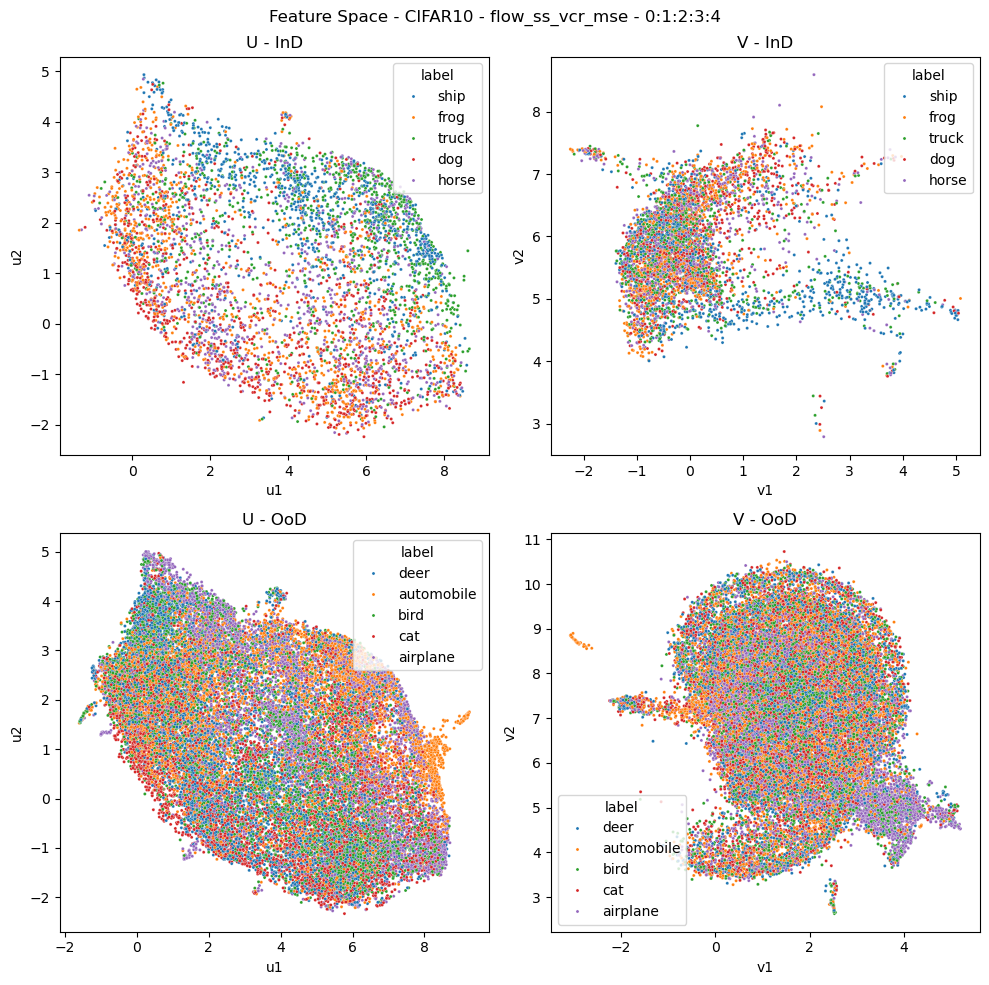

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

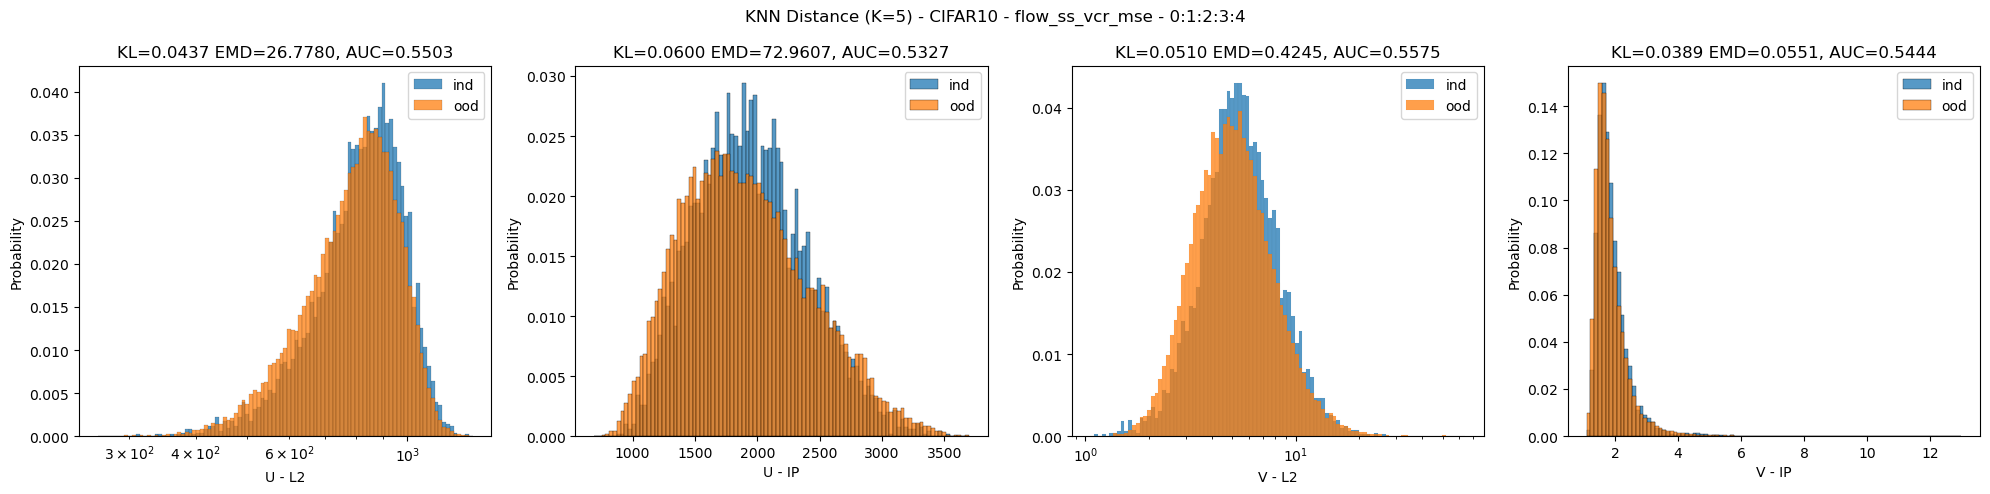

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

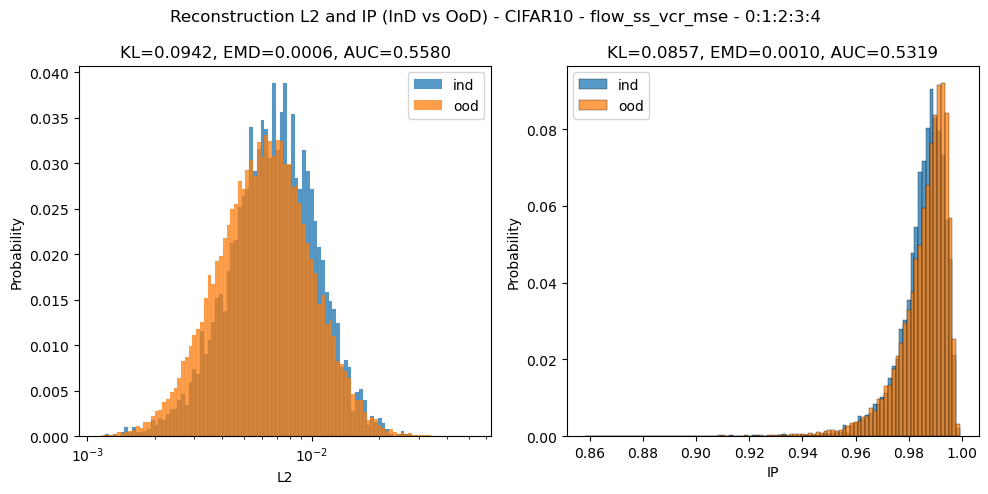

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

43.804077 5.5890765 2.3902316 0.49303314
43.688183 5.6365485 2.3761039 0.4950196
44.045063 5.575208 2.3878567 0.49246022
43.21861 6.487458 2.3103411 0.5199572
60.11506 2.5981138 46.81357 0.76972705


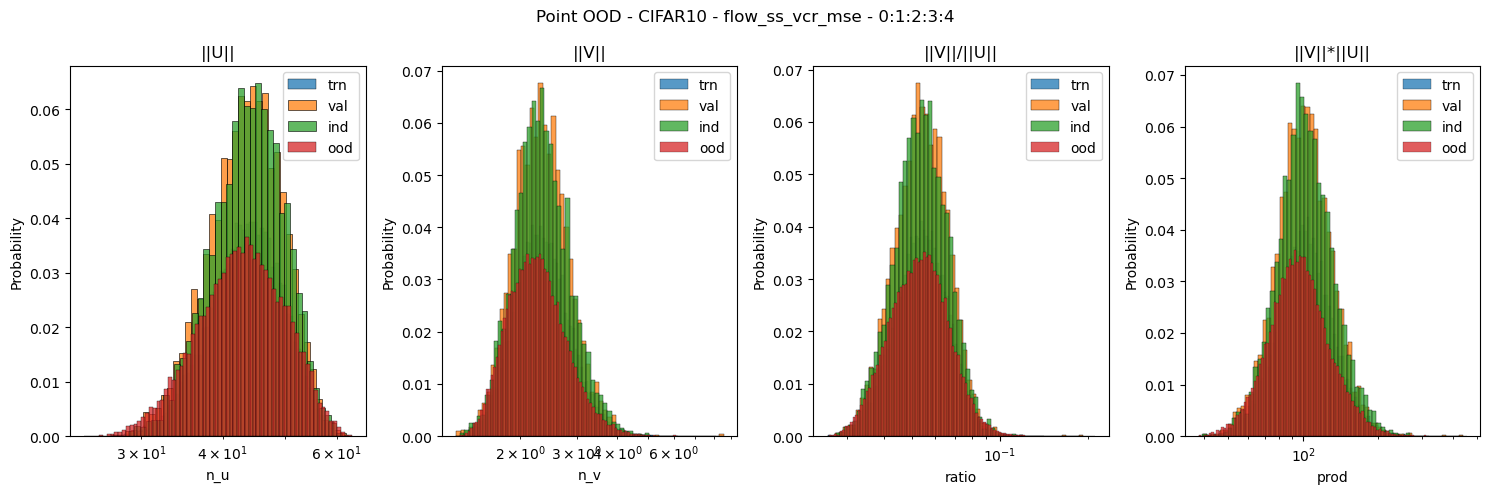

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


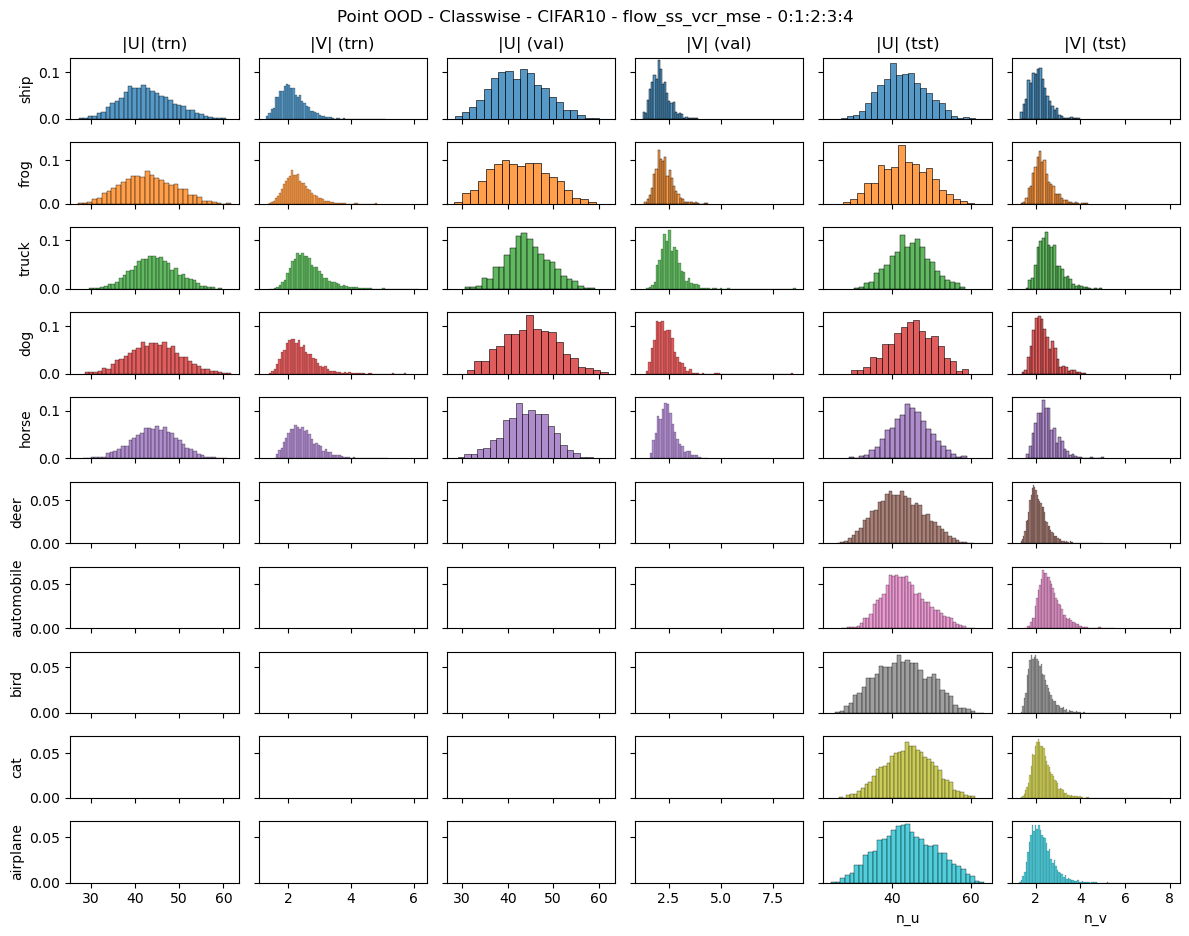

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

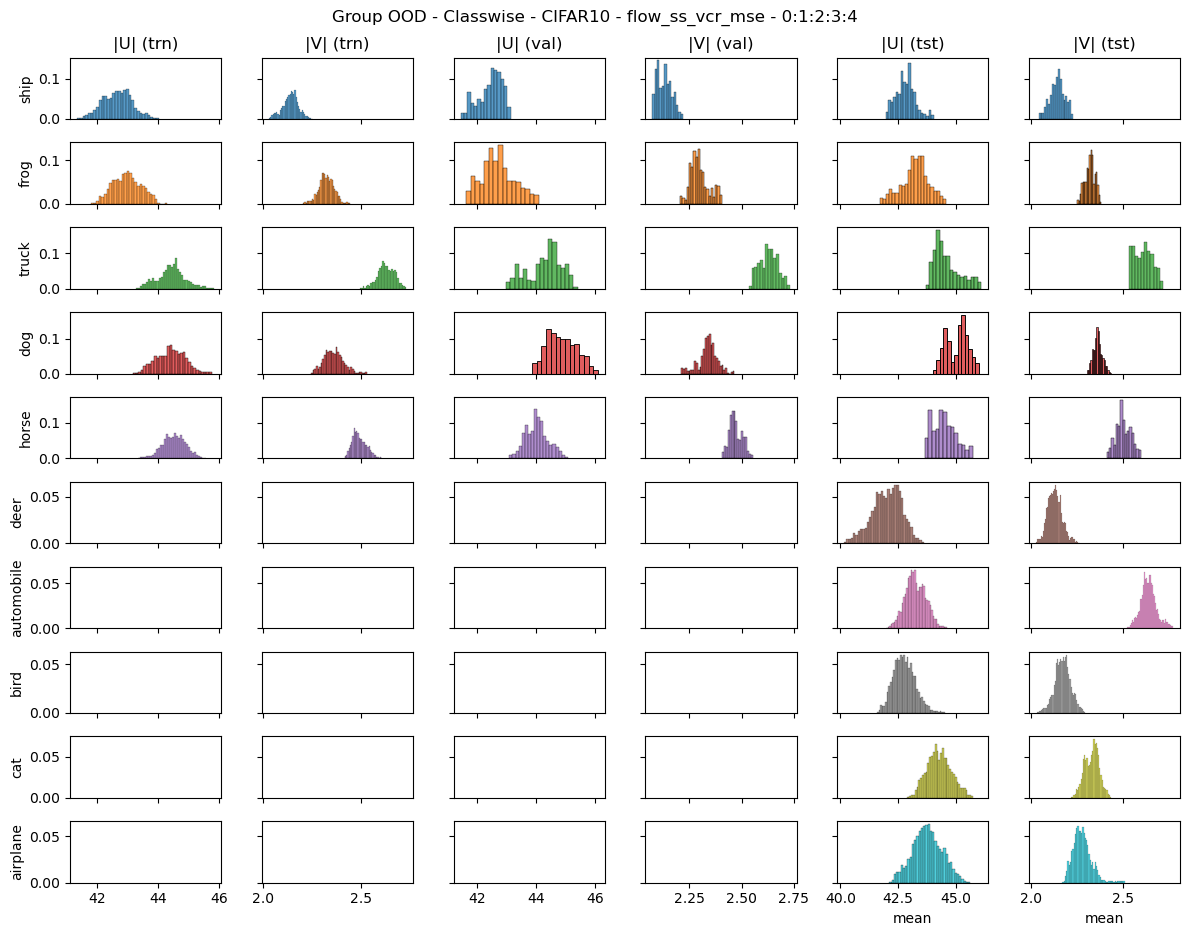

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()